In [6]:
import torch
import torch.optim as optim
import pickle 
import os

import numpy as np
import pandas as pd
from utils.vmf_batch import vMF

from models import SeqEncoder, SeqDecoder, Seq2Seq_VAE, PoolingClassifier, init_weights
from utils.training_utils import train, evaluate

## plotting ###

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
SEED = 17
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
device

device(type='cuda')

In [4]:
def scale(X,scale=(.1,3)):
    a = scale[0]
    b = scale[1]
    s = a + (b-a)*torch.rand(1)
    return X*s

### load iterator

In [5]:
path = './data/%s/iterator/%s/%s%s.pkl'
part = 'soma_centered'
folder = 'Farrow_data'
prefix = 'scaling_'

with open(path%(folder, part, prefix, 'train_iterator'), 'rb') as f:
    train_iterator = pickle.load(f)
    
with open(path%(folder, part, prefix, 'val_iterator'), 'rb') as f:
    val_iterator = pickle.load(f)    

In [6]:
src_data, trg_data, seq_len, indices, labels = list(train_iterator)[0]
bs, n_walks, walk_length, output_dim = src_data.shape

N_train = len(train_iterator.sampler.indices)
N_val = len(val_iterator.sampler.indices)

### load model

In [7]:
emb_dim = 32
latent_dim = 32
NUM_LAYERS = 2
dpout = .1
kap = 500
pool = 'max'
lr = 0.01
MASKING_ELEMENT = train_iterator.dataset.masking_el

# get number of labels, ignore -100 index
l = list(np.unique(labels))
if -100 in l:
    l.remove(-100)
NUM_CLASSES = len(l)

In [8]:
NUM_CLASSES

14

In [9]:
enc = SeqEncoder(output_dim, emb_dim, emb_dim, NUM_LAYERS, dpout)
dec = SeqDecoder(output_dim, emb_dim, emb_dim, NUM_LAYERS, dpout)
dist = vMF(latent_dim, kappa=kap)
model = Seq2Seq_VAE(enc, dec, dist, device).to(device)
classifier = PoolingClassifier(latent_dim, NUM_CLASSES, n_walks,dpout,pooling=pool).to(device)

KLD: 45.709938049316406


In [10]:
def calculate_loss(x, reconstructed_x, ignore_el=MASKING_ELEMENT):
    # reconstruction loss
    # x = [trg len, batch size * n walks, output dim]

    seq_len , bs, output_dim = x.shape
    mask = x[:,:,0] != ignore_el
    RCL = 0
    for d in range(output_dim):
        RCL += mse_loss(reconstructed_x[:,:,d][mask], x[:,:,d][mask])
    RCL /= output_dim
    
    return RCL

In [11]:
torch.cuda.empty_cache()

In [12]:
path = "./models/Farrow/scratch/soma_centered"
import os 
os.makedirs(path, exist_ok=True)

In [13]:

N_EPOCHS= 150
save_path_model= './models/Farrow/scratch/%s/vae_frac%.1f_scaled_best_run%i.pt'
save_path_losses = './models/Farrow/scratch/%s/losses_frac%.1f_scaled_run%i.npy'
save_path_elapsed_time = './models/Farrow/scratch/%s/elapsed_time_frac%.1f_scaled_run%i.npy'

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)


for frac in [0.]:  
    runs = range(1,4)
        
    for run in runs:
        
        
        if os.path.exists(save_path_model%(part,frac,run)):
            state_dict = torch.load(save_path_model%(part,frac,run))
        else:
            state_dict = None
        #optimizer
        optimizer = optim.Adam(list(model.parameters()) + list(classifier.parameters()), lr=lr)
        # load pre-trained model
        if state_dict is not None:
            model.load_state_dict(state_dict['model_state_dict'])
            
            optimizer.load_state_dict(state_dict['optimizer_state_dict'])
            classifier.load_state_dict(state_dict['classifier_state_dict'])
            losses = np.load(save_path_losses%(part, frac, run))
            elapsed_time = np.load(save_path_elapsed_time%(part, frac, run))
            
            last_epoch = state_dict['epoch']
            training = list(losses[:last_epoch,:2])
            validation = list(losses[:last_epoch,2:])
            
            best_test_loss = losses[:,2].min()
            
        else:
            model.apply(init_weights)
            classifier.apply(init_weights)
            best_test_loss = np.infty
            
            training = []
            validation=[]
            last_epoch = 0
            elapsed_time = np.zeros((N_EPOCHS,))
            
        
        cross_entropy_loss = torch.nn.CrossEntropyLoss(reduction='sum', ignore_index=-100)
        mse_loss = torch.nn.MSELoss(reduction='sum')

        
        for e in range(last_epoch, N_EPOCHS):
            start.record()
            train_loss, train_class_loss = train(model, classifier, train_iterator, optimizer, 
                                               calculate_loss,cross_entropy_loss, clip=1, norm_p=None,
                                                 class_fraction=frac)
            val_loss, val_class_loss = evaluate(model,classifier, val_iterator,
                                                 calculate_loss, cross_entropy_loss, norm_p=None)
            
            end.record()

            # Waits for everything to finish running
            torch.cuda.synchronize()
            elapsed_time[e] = start.elapsed_time(end) # milliseconds

            train_loss /= N_train
            train_class_loss /= N_train
            val_loss /= N_val
            val_class_loss /=N_val

            training += [[train_loss,train_class_loss]]
            validation += [[val_loss, val_class_loss]]
            print(f'Epoch {e}, Train Loss: {train_loss:.2f}, Val Loss: {val_loss:.2f}, \
                  Time elapsed [s]: {elapsed_time[e]/1000:.2f}')
            
            

            if e % 50 == 0 and e > 0:
                optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr']/2

            if best_test_loss > val_loss:
                best_test_loss = val_loss
                torch.save({'epoch': e,
                            'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'classifier_state_dict': classifier.state_dict()
                               },save_path_model%(part,frac, run))

                validation_ = np.array(validation)
                training_ = np.array(training)
                # [:,0] = training loss, [:,1] = training classification losss
                # [:,2] validation loss, [:,3] validation classification loss
                losses = np.hstack((training_, validation_))
                np.save(save_path_losses%(part,frac, run),losses)
                np.save(save_path_elapsed_time%(part,frac, run),elapsed_time)
                
            
            
        validation = np.array(validation)
        training = np.array(training)
        losses = np.hstack((training, validation))
        np.save(save_path_losses%(part,frac, run), losses)
        np.save(save_path_elapsed_time%(part,frac, run),elapsed_time)
        
torch.cuda.empty_cache()

Epoch 145, Train Loss: 30.17, Val Loss: 596.68,                   Time elapsed [s]: 18.85
Epoch 146, Train Loss: 30.35, Val Loss: 610.89,                   Time elapsed [s]: 18.67
Epoch 147, Train Loss: 30.83, Val Loss: 592.44,                   Time elapsed [s]: 18.74
Epoch 148, Train Loss: 30.00, Val Loss: 590.40,                   Time elapsed [s]: 18.74
Epoch 149, Train Loss: 29.48, Val Loss: 601.28,                   Time elapsed [s]: 18.71
Epoch 147, Train Loss: 29.56, Val Loss: 597.78,                   Time elapsed [s]: 18.81
Epoch 148, Train Loss: 29.97, Val Loss: 575.87,                   Time elapsed [s]: 18.77
Epoch 149, Train Loss: 31.97, Val Loss: 579.90,                   Time elapsed [s]: 18.78
Epoch 139, Train Loss: 27.88, Val Loss: 582.65,                   Time elapsed [s]: 18.81
Epoch 140, Train Loss: 27.25, Val Loss: 581.87,                   Time elapsed [s]: 18.81
Epoch 141, Train Loss: 26.59, Val Loss: 588.51,                   Time elapsed [s]: 18.83
Epoch 142,

In [4]:
import torch
z = torch.load('./models/Farrow/scratch/soma_centered/vae_frac0.0_scaled_best_run2.pt')

In [5]:
z['epoch']

148

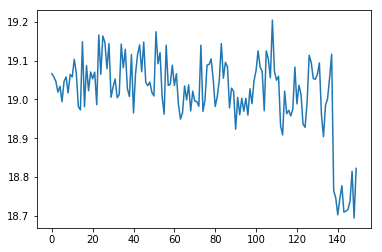

In [14]:
plt.plot(elapsed_time/1000)

In [15]:
print(elapsed_time.mean()/1000)
print(elapsed_time.std()/1000)


19.01770216145833
0.1001709483872186
